In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

%matplotlib inline

# plt.style.use('seaborn-v0_8-colorblind')

plt.style.use('ggplot')

In [3]:
data_path = "../datasets/unloaded-res.csv"
dedicated_path = "../datasets/dedicated-res.csv"
data_path_remake = "../datasets/02-unloaded-res.csv"

df_before = pd.read_csv(data_path)
df = pd.read_csv(dedicated_path)
# df = pd.read_csv(dedicated_remake)

df.time = df.time.astype(int)
df.time = df.time - 1

dedicated.time = dedicated.time.astype(int)
dedicated.time = dedicated.time -1

df_before.time = df_before.time.astype(int)
df_before.time = df_before.time - 1

In [4]:

# lets create time series from weather 
# timeSeries = weather_bin.loc[:, ["Date","MeanTemp"]]
# timeSeries.index = timeSeries.Date
# ts = timeSeries.drop("Date",axis=1)

latencia = df[['time', 'latency_median']]
# dedicado = dedicated[['time', 'latency_median']]

latencia = latencia.set_index('time')
# dedicado = dedicado.set_index('time')

latencia.head()


,latency_median
time,
1,227
2,208
3,210
4,230
5,219


In [5]:
ts = latencia.latency_median

ts.head()

time
1    227
2    208
3    210
4    230
5    219
Name: latency_median, dtype: int64

In [6]:
df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1,1001,1000,161,227,254,412,647
1,2,1000,1001,156,208,228,310,463
2,3,1001,1001,144,210,238,407,570
3,4,1000,1000,163,230,256,414,1072
4,5,1001,1001,150,219,248,430,670


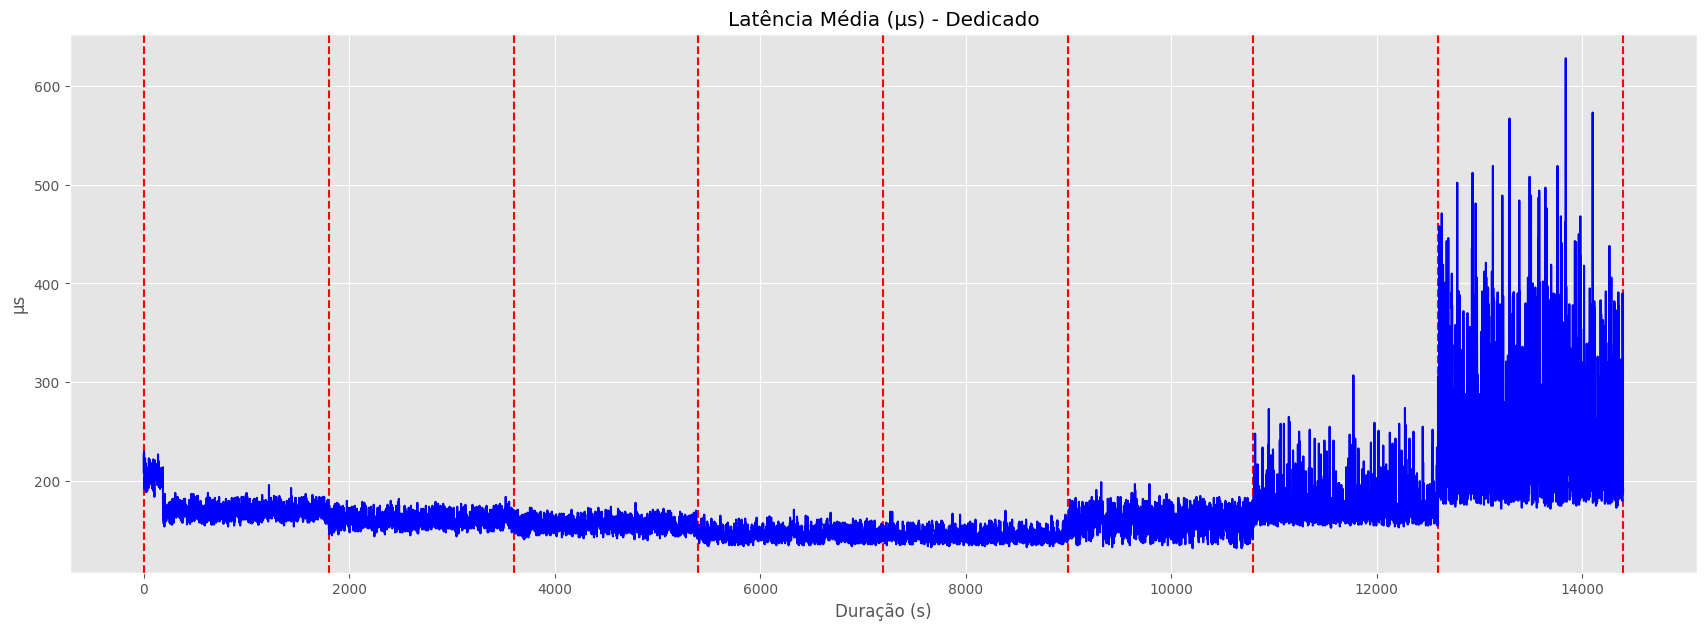

In [16]:
plt.figure(figsize=(21, 7))

assintotas = [0, 1800, 3600, 5400, 7200, 9000, 10800, 12600, 14400]
for x in assintotas:
    plt.axvline(x=x, color='red', linestyle='--', label=f'Assíntota em x = {x}')

plt.plot(latencia, color='blue')
plt.title('Latência Média (µs) - Dedicado')
plt.xlabel('Duração (s)')
plt.ylabel("µs")
# plt.grid(True)
plt.show()

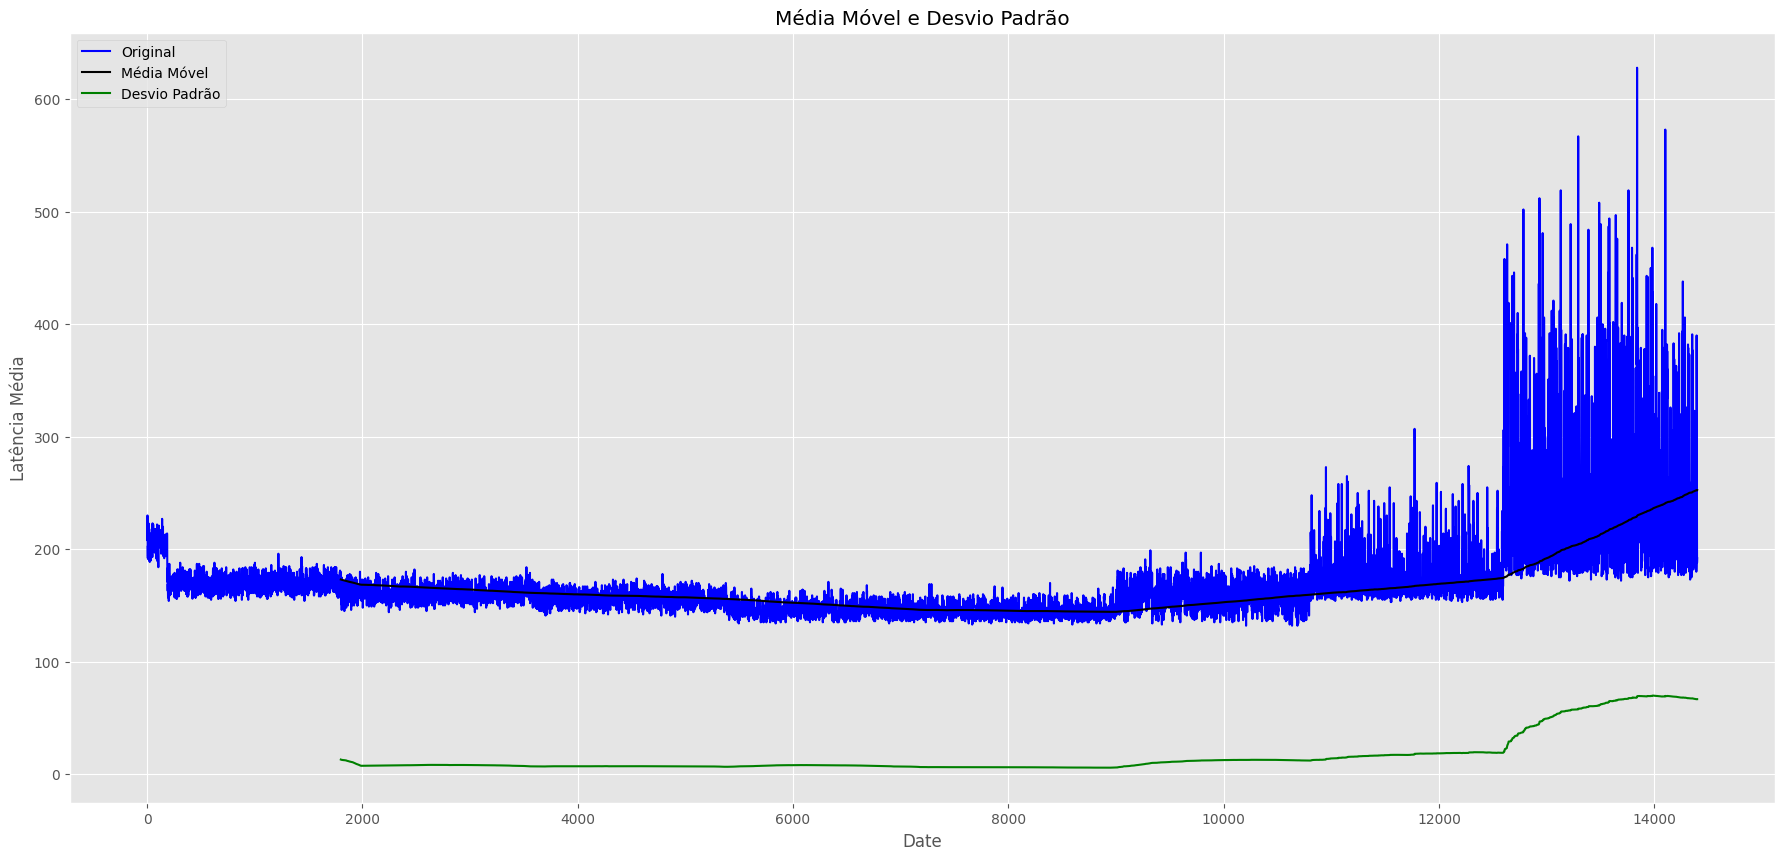

Test statistic:  -2.980883717668964
p-value:  0.03671859732888749
Critical Values: {'1%': np.float64(-3.430805591366162), '5%': np.float64(-2.861741351011649), '10%': np.float64(-2.566877174398671)}


In [8]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    rolmean = pd.Series(ts).rolling(window=1800).mean()
    rolstd = pd.Series(ts).rolling(window=1800).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='blue', label='Original')
    mean = plt.plot(rolmean, color='black', label='Média Móvel')
    std = plt.plot(rolstd, color='green', label = 'Desvio Padrão')
    plt.xlabel("Date")
    plt.ylabel("Latência Média")
    plt.title('Média Móvel e Desvio Padrão')
    plt.legend()
    plt.show()
    
check_mean_std(ts)
check_adfuller(ts)

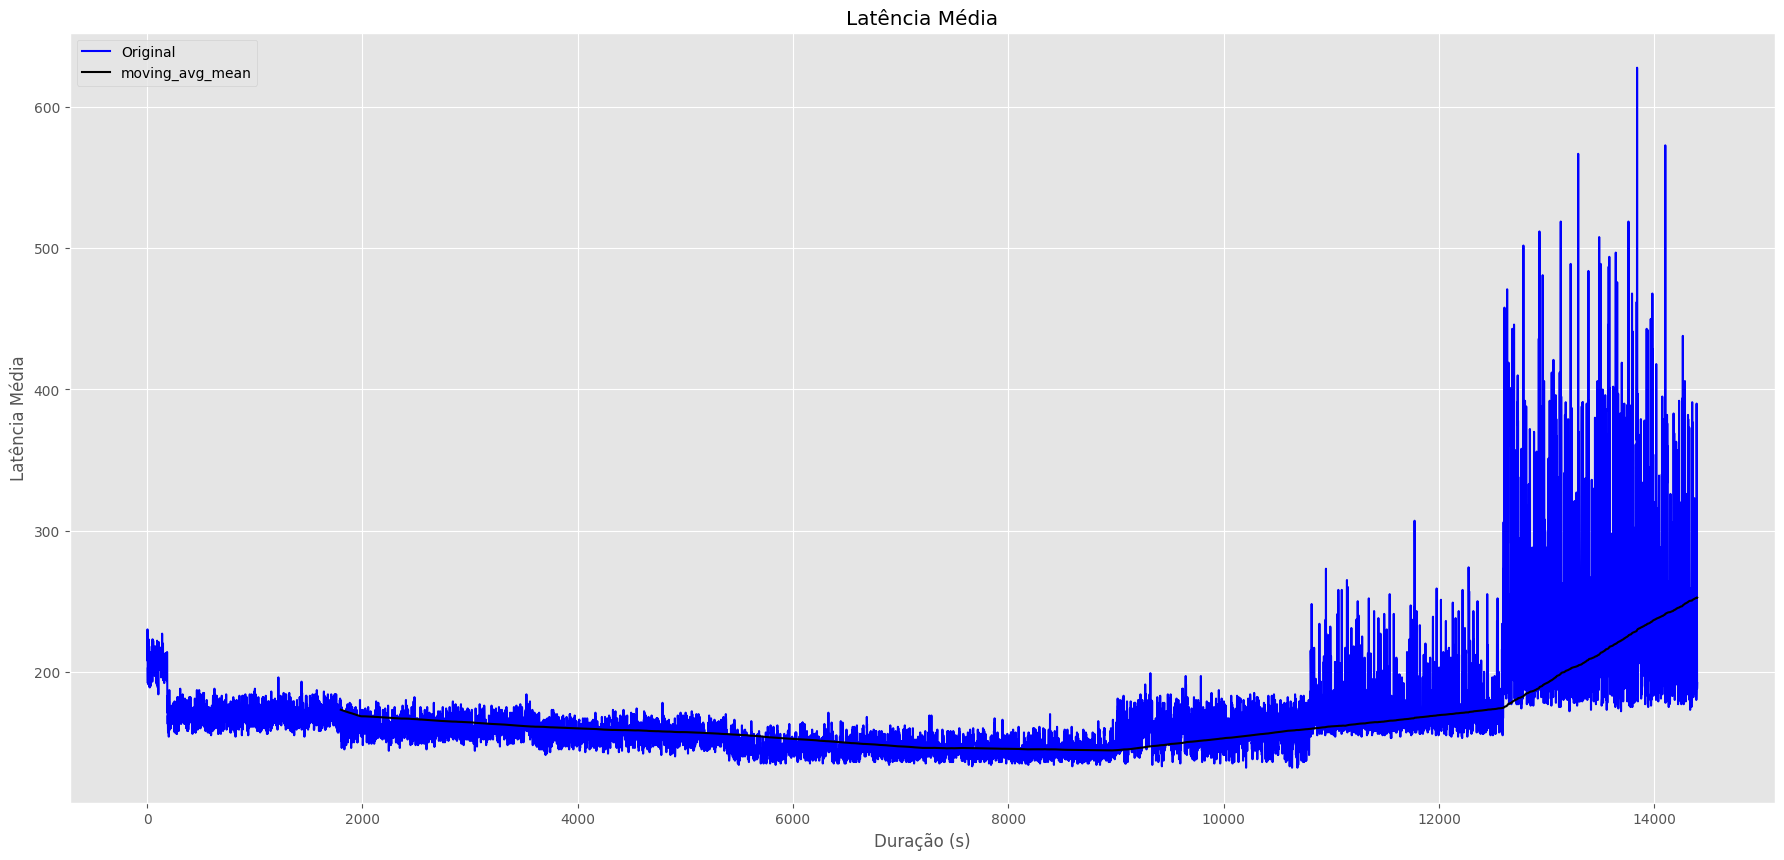

In [9]:

window_size = 6
moving_avg = pd.Series(ts).rolling(window=1800).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color='blue', label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Latência Média")
plt.xlabel("Duração (s)")
plt.ylabel("Latência Média")
plt.legend()
plt.show()



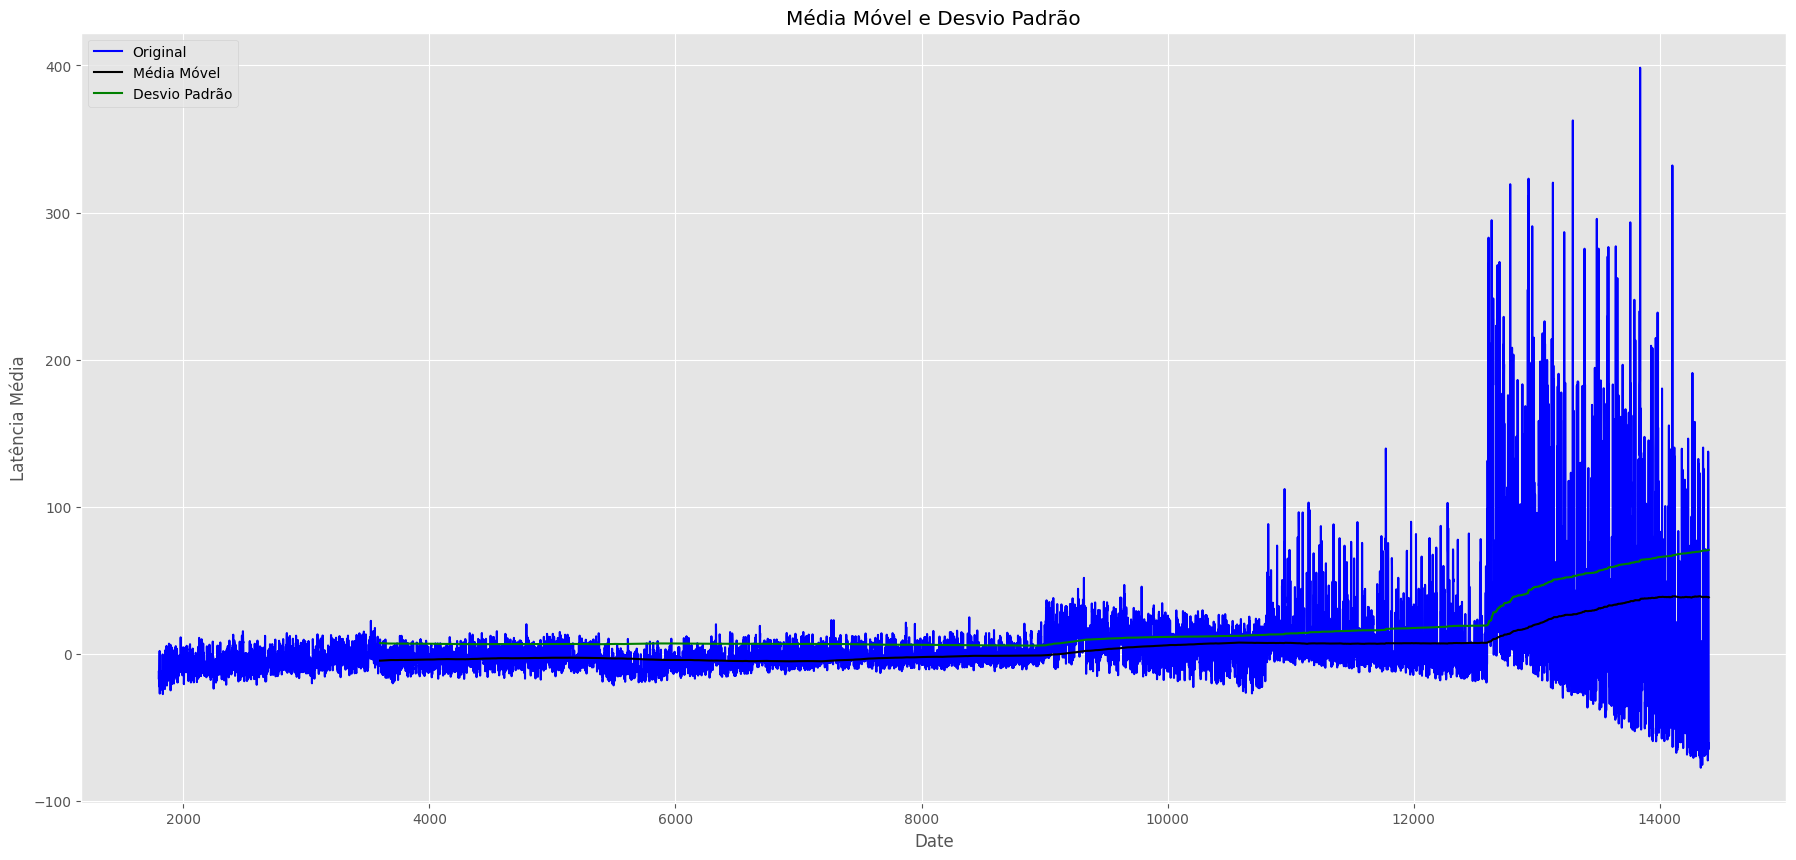

Test statistic:  -6.090043676995252
p-value:  1.041766876767637e-07
Critical Values: {'1%': np.float64(-3.4308708343033523), '5%': np.float64(-2.8617701829439), '10%': np.float64(-2.566892521395295)}


In [10]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True)

check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff)

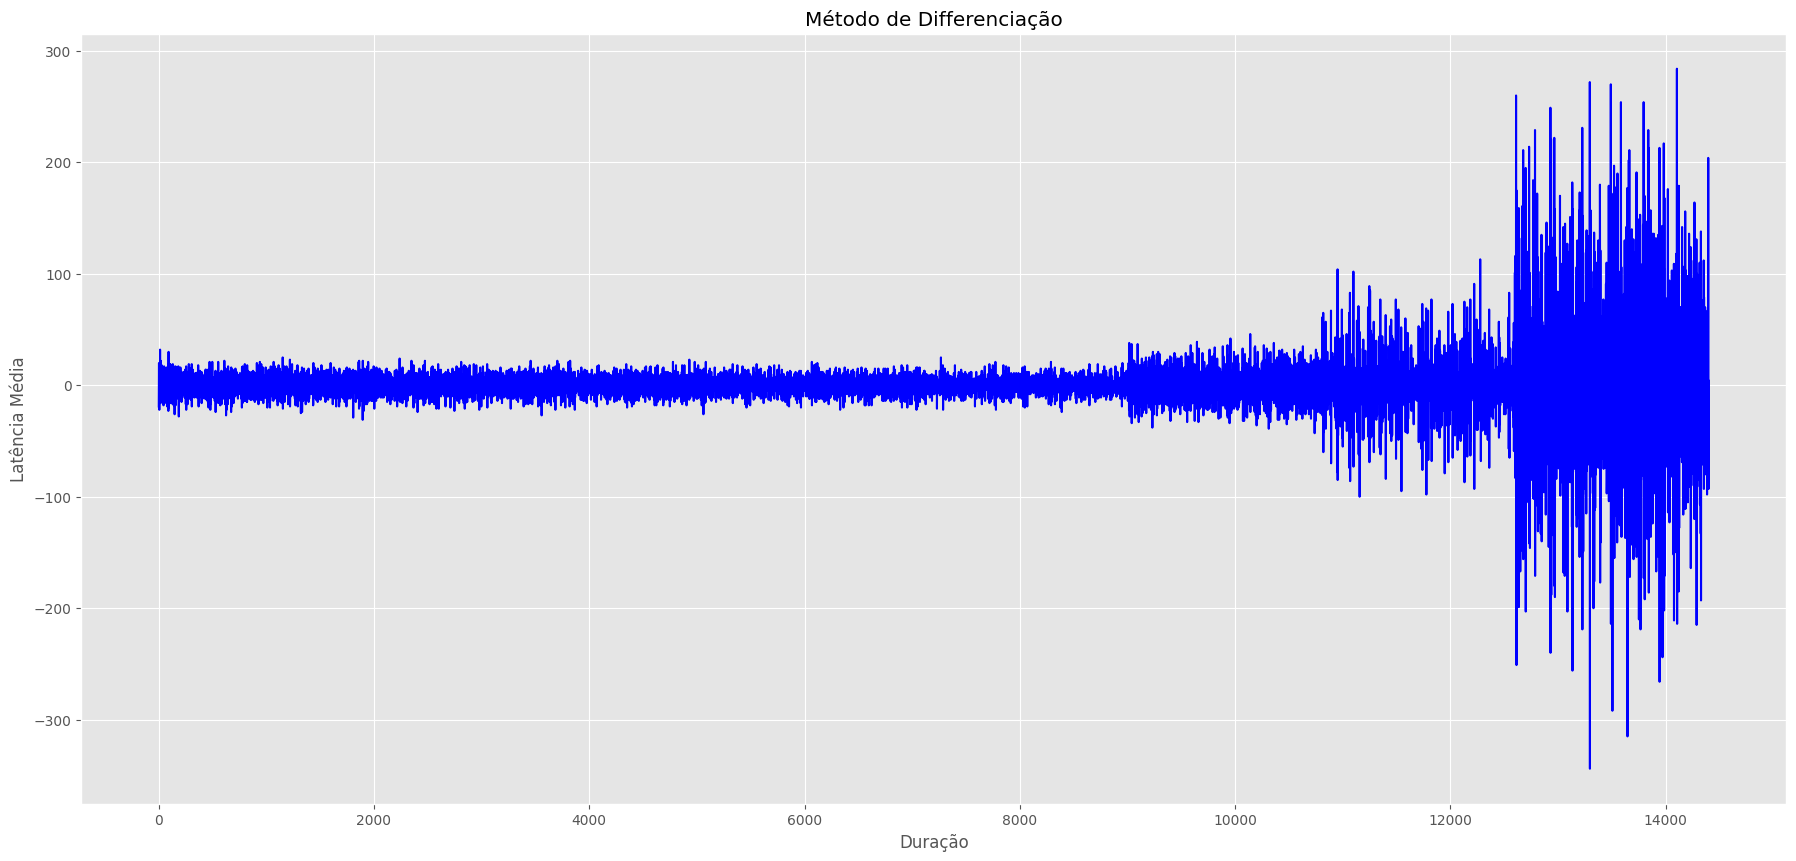

In [13]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff, color='blue')
plt.title("Método de Differenciação") 
plt.xlabel("Duração")
plt.ylabel("Latência Média")
plt.show()

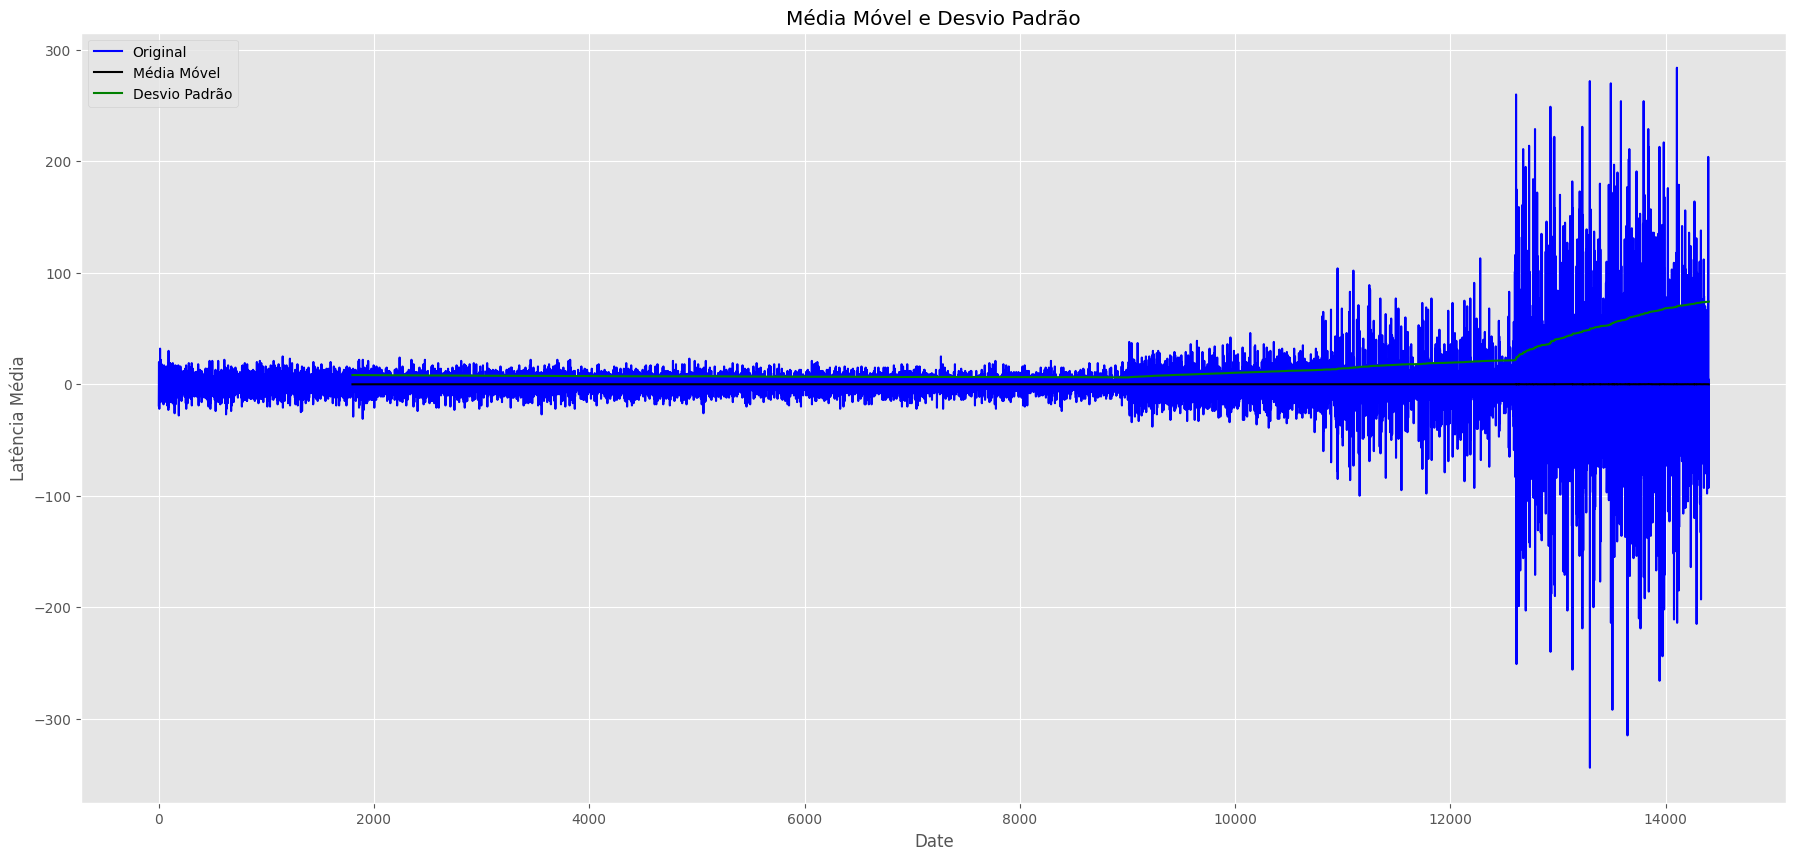

Test statistic:  -32.66266703824308
p-value:  0.0
Critical Values: {'1%': np.float64(-3.430805591366162), '5%': np.float64(-2.861741351011649), '10%': np.float64(-2.566877174398671)}


In [14]:
ts_diff.dropna(inplace=True)

check_mean_std(ts_diff)
check_adfuller(ts_diff)



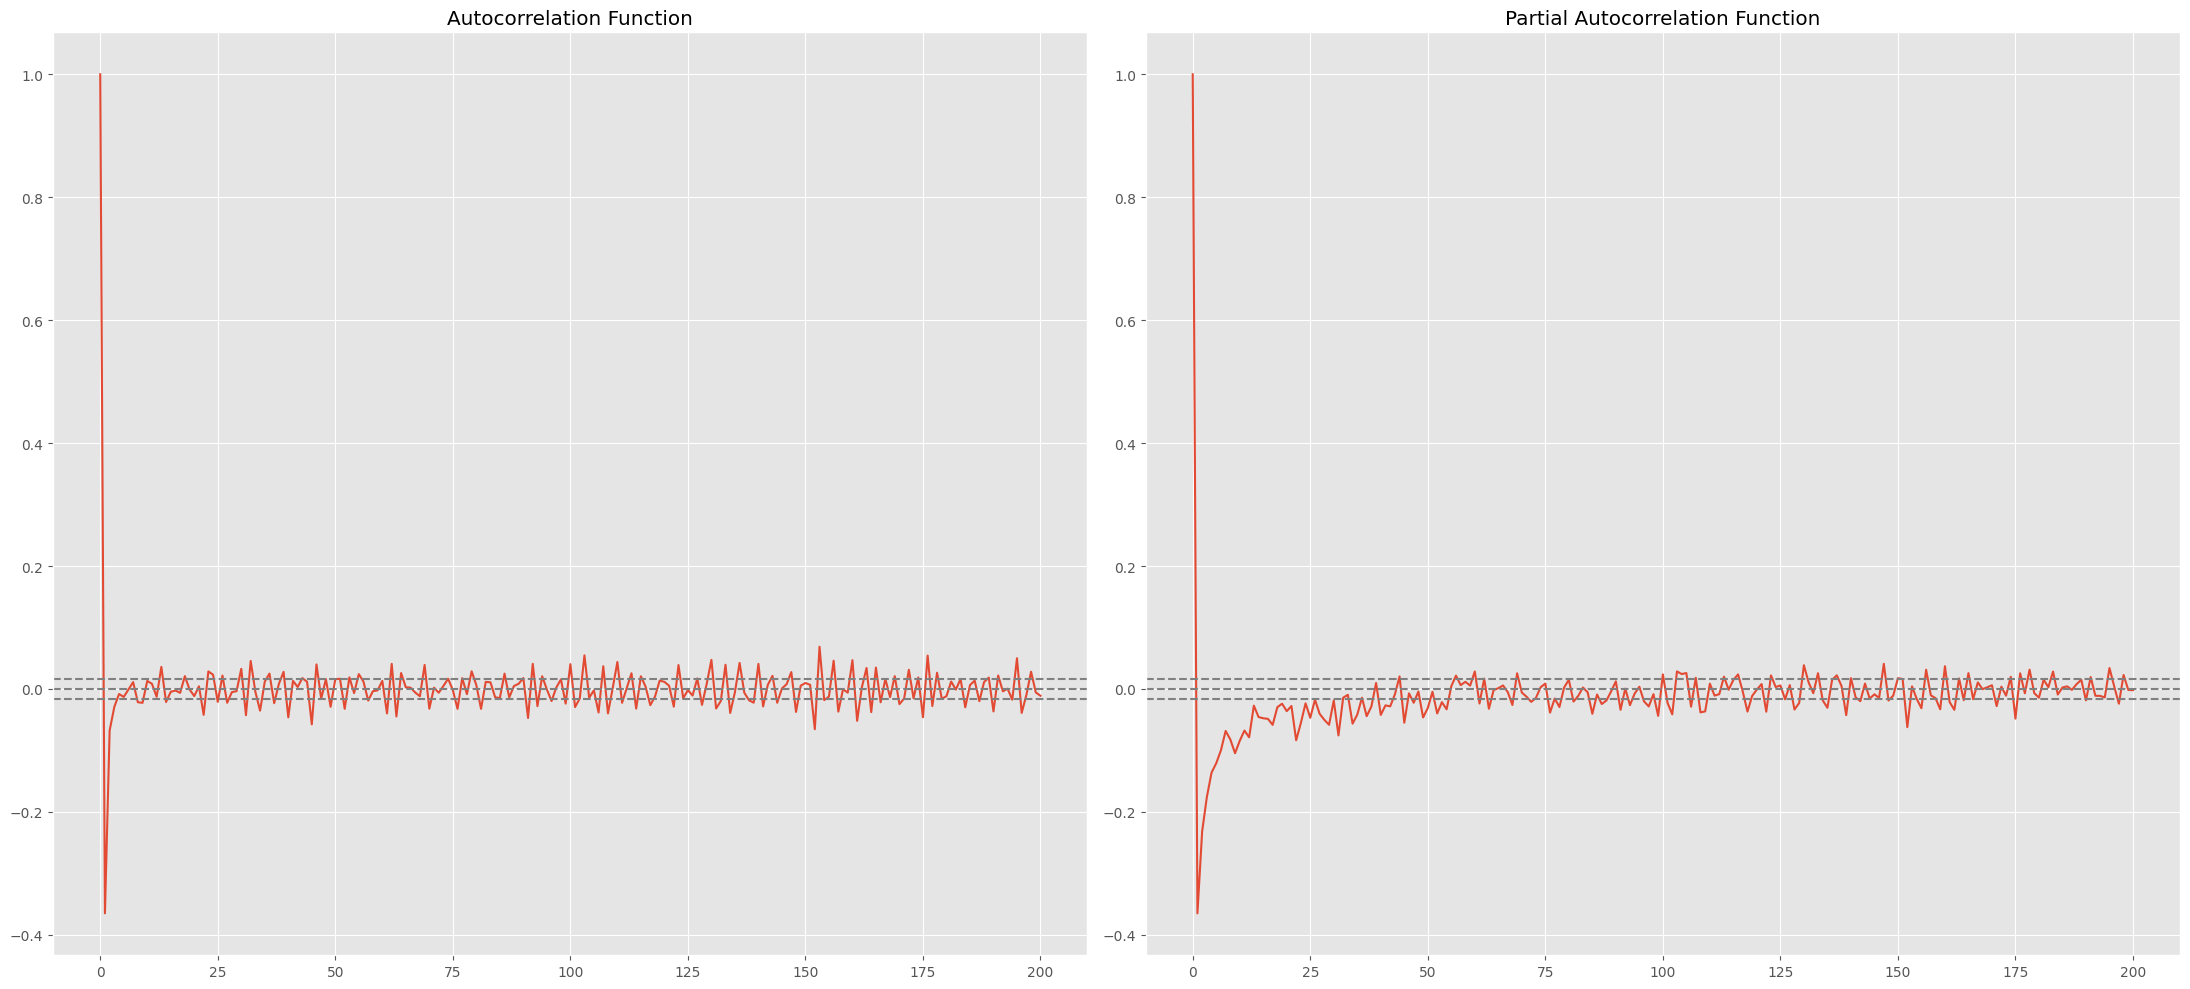

In [15]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=200)
lag_pacf = pacf(ts_diff, nlags=200, method='ols')


# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

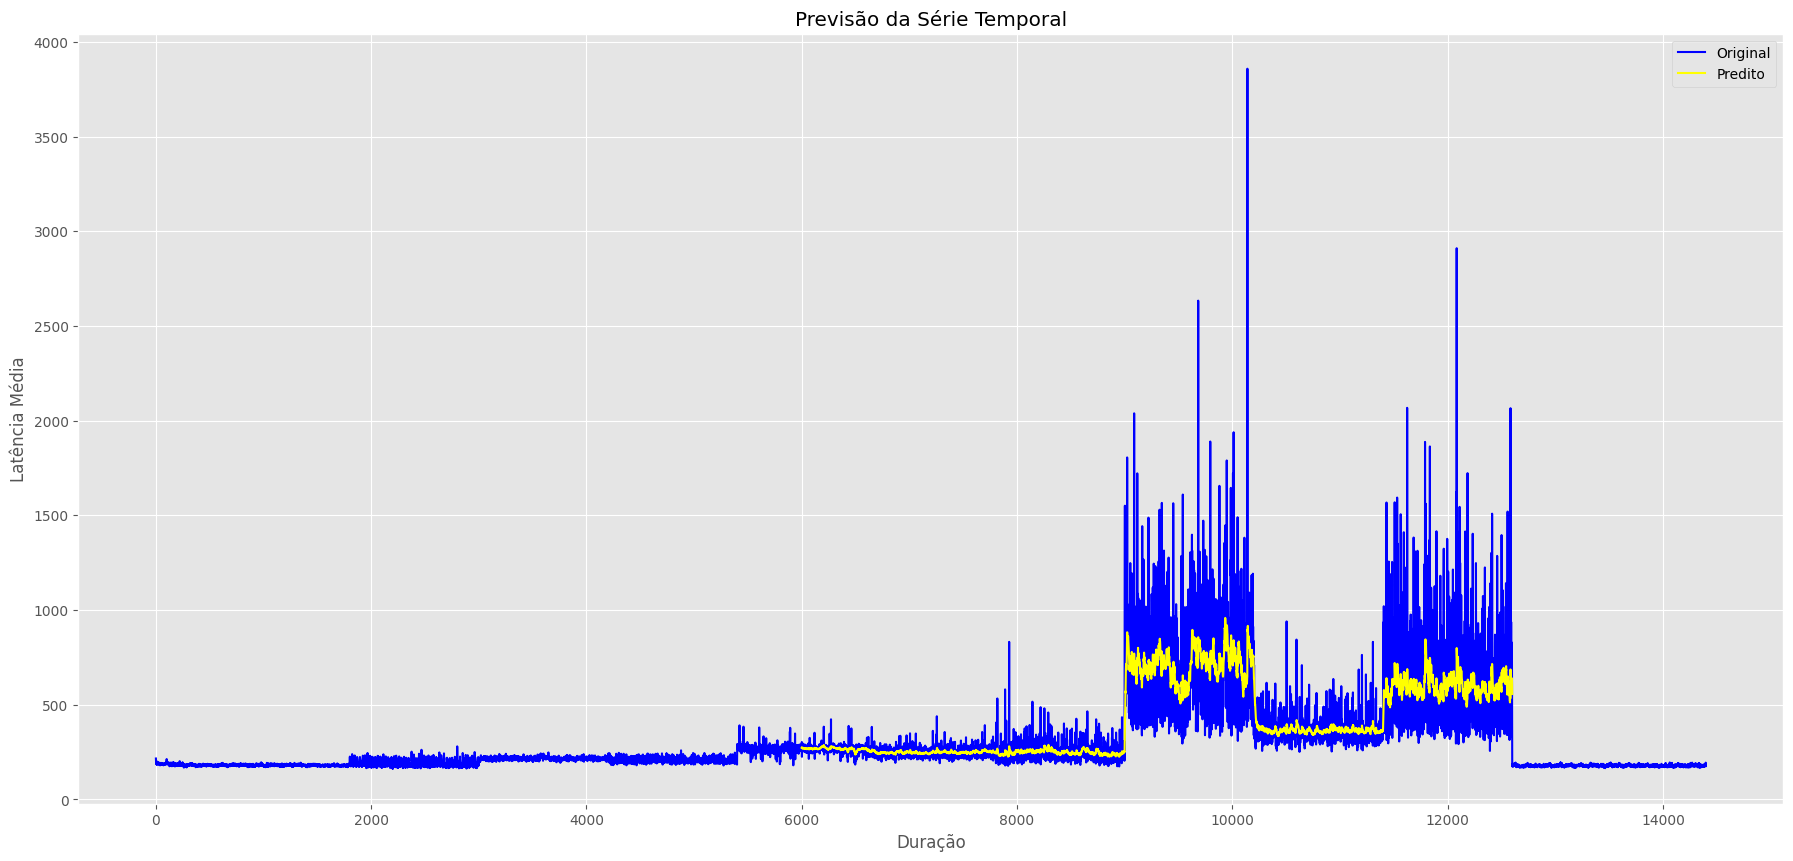

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Ajuste o 'ts' para a sua série temporal (por exemplo, 'latencia' ou 'ts')
# ts = seu_data_series

# Ajuste o modelo ARIMA
model = ARIMA(ts, order=(1,0,1))  # ARMA (1,0,1) com p=1, d=0, q=1
model_fit = model.fit()

# Previsão
start_index = 1800
end_index = 12600
forecast = model_fit.predict(start=start_index, end=end_index)

# Visualização
plt.figure(figsize=(22, 10))
plt.plot(ts, label="Original", color='blue')  # Série original
plt.plot(range(start_index, end_index+1), forecast, label="Predito", color='yellow')  # Previsão
plt.title("Previsão da Série Temporal")
plt.xlabel("Duração")
plt.ylabel("Latência Média")
plt.legend()
plt.show()


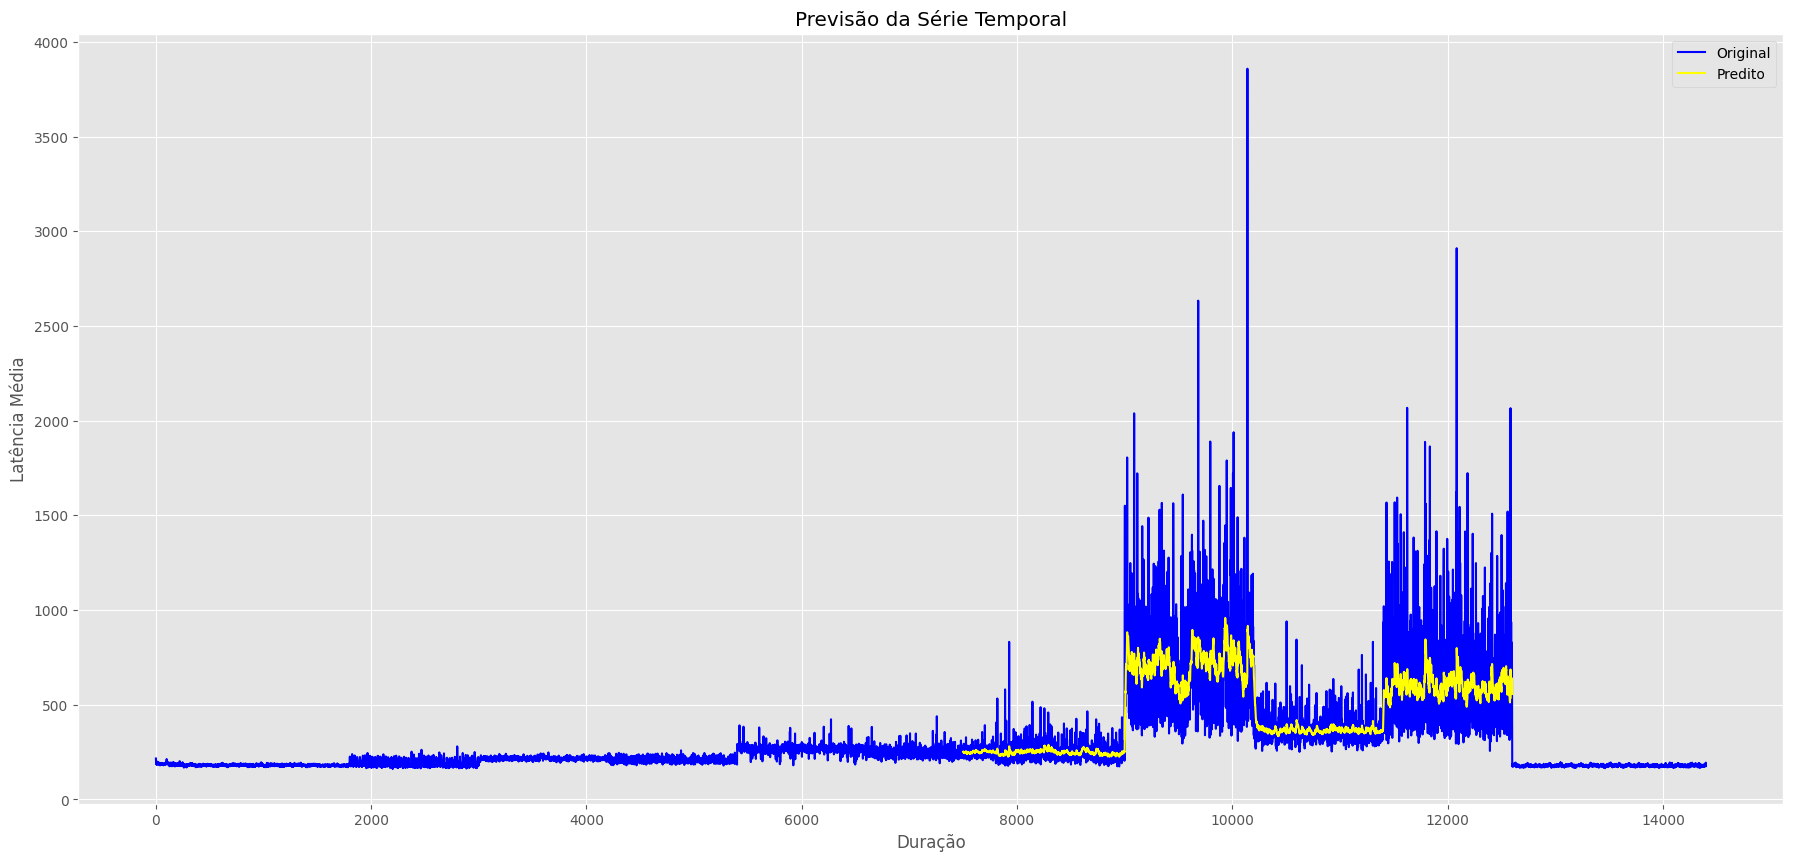

In [95]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Ajuste o 'ts' para a sua série temporal (por exemplo, 'latencia' ou 'ts')
# ts = seu_data_series

# Ajuste o modelo ARIMA
model = ARIMA(ts, order=(1,0,1))  # ARMA (1,0,1) com p=1, d=0, q=1
model_fit = model.fit()

# Previsão
start_index = 7500
end_index = 12600
forecast = model_fit.predict(start=start_index, end=end_index)

# Visualização
plt.figure(figsize=(22, 10))
plt.plot(ts, label="Original", color='blue')  # Série original
plt.plot(range(start_index, end_index+1), forecast, label="Predito", color='yellow')  # Previsão
plt.title("Previsão da Série Temporal")
plt.xlabel("Duração")
plt.ylabel("Latência Média")
plt.legend()
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

